# Using just TensorFlow Framework, without `Keras`

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import tensorflow as tf

### Step 1: Load the `IRIS` dataset

In [3]:
path = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/iris.csv' #import IRIS dataset
df = pd.read_csv(path, header=None)

In [4]:
df.head(2)

,0,1,2,3,4
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa


In [5]:
headers = ["sepal_length", "sepal_width", "petal_length", "petal_width", "species"]
### Assign the headers to `df`
df.columns = headers

df.sample(2)

,sepal_length,sepal_width,petal_length,petal_width,species
80,5.5,2.4,3.8,1.1,Iris-versicolor
146,6.3,2.5,5.0,1.9,Iris-virginica


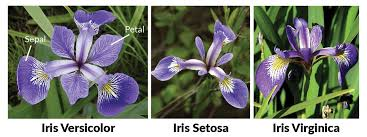

In [6]:
### Import SKlearn libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [7]:
### Let us prepare the data - separating the features from the target
X, y = df.values[:,:-1], df.values[:,-1]

In [10]:
X[:2]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3.0, 1.4, 0.2]], dtype=object)

In [11]:
y[:2]

array(['Iris-setosa', 'Iris-setosa'], dtype=object)

In [12]:
X = X.astype('float32')

In [13]:
y = LabelEncoder().fit_transform(y)

In [14]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

### Step 2: Split the `IRIS` dataset into `train` and `test`

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.30, random_state=42)

In [62]:
X_train.shape, X_test.shape

((105, 4), (45, 4))

In [63]:
45/150*100

30.0

### Step 3: Build the neural network model

In [64]:
### Dertermine the number of features
n_features = X_train.shape[1]
print('Number of features:',n_features)

### Determine the number of classes
n_classes = len(np.unique(y))
print('Number of classes:', n_classes)

Number of features: 4
Number of classes: 3


#### Step 3a: Define the model

**`MLPModel:`Multi Layer Perceptron Model**

*   initialize the weights and biases for each layer
*   implement the forward pass


In [65]:
class MLPModel(tf.Module):
  def __init__(self):#initializes weights and biases for each layer

    ### represents weight and bias for the first layer
    self.w1 = tf.Variable(tf.random.normal([n_features, 10], stddev=0.1), name='w1') #creating a TF variable 'w1' with dimensions: n_features, 10 neurons and initializing w1 with random values drawn from a normal distribution having std. deviaton of 0.1
    self.b1 = tf.Variable(tf.zeros([10]), name='b1')

    ###  Initializing weights 'w2' and bias 'b2`while connecting 10 neurons from the first layer to 8 in the second layer
    self.w2 = tf.Variable(tf.random.normal([10, 8], stddev=0.1), name='w2')
    self.b2 = tf.Variable(tf.zeros([8]), name='b2')

    ###  Initializing weights 'w3' and bias 'b3`while connecting 8 neurons from the second layer to n_classes [3] in the output layer
    self.w3 = tf.Variable(tf.random.normal([8, n_classes], stddev=0.1), name='w3')
    self.b3 = tf.Variable(tf.zeros([n_classes]), name='b3')

  def __call__(self, x):# to implement the forward pass

    ### represents weight and bias for the first layer
    ### ReLU (REctified Linear Unit) - an activation function
    layer1 = tf.nn.relu(tf.add(tf.matmul(x,self.w1), self.b1)) # performing a matrix multiplication between input features and the weight matrix. Also adding the bias matrix after in the next using `tf.add`
    layer2 = tf.nn.relu(tf.add(tf.matmul(layer1,self.w2), self.b2))
    output = tf.add(tf.matmul(layer2,self.w3), self.b3)
    return output

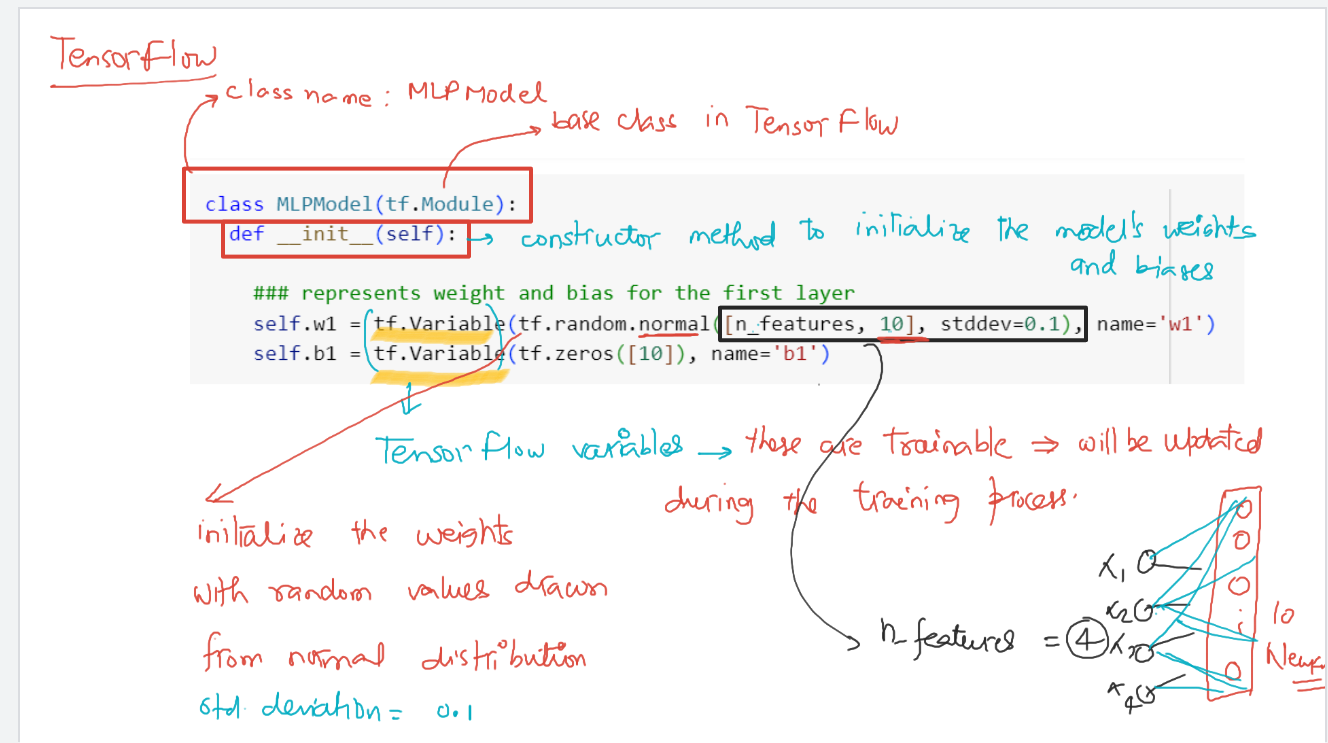**bold text**

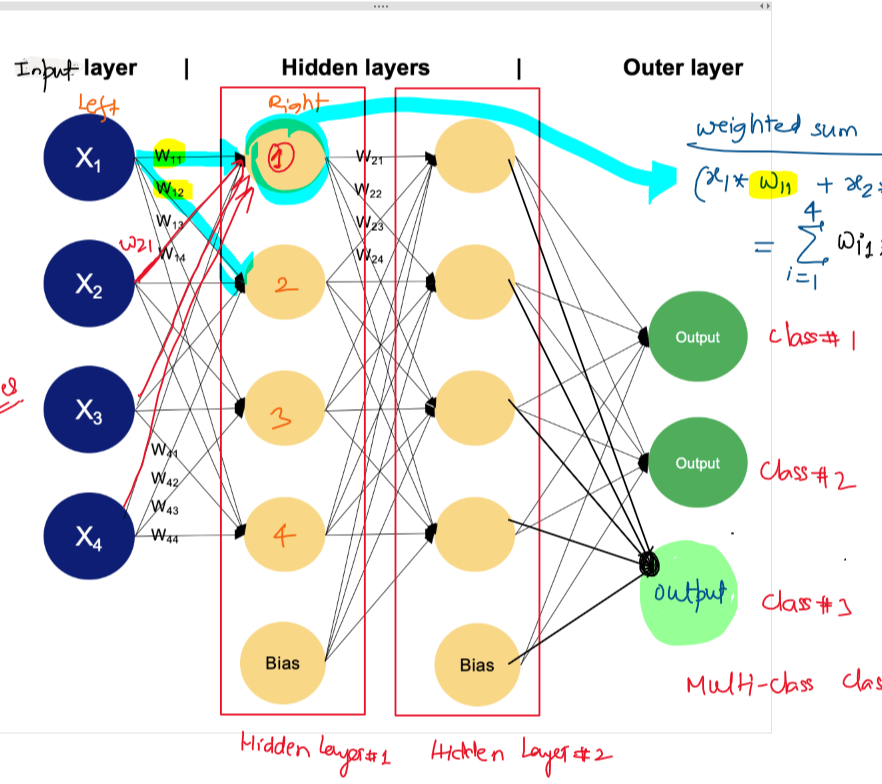

-- Why did we not use any `activation function in the output layer` -- let us discuss later!

#### Step 3b: Instantiate the model





In [66]:
model = MLPModel()

In [67]:
loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=True) # Crossentropy loss for multi-class classification
optimizer = tf.optimizers.Adam() #Adam optimizer for training

#### Step 3c: Training Steps

In [68]:
### Training Function
@tf.function # compiles the function into a TensorFlow graph for efficiency
def train_step(x,y): #Performs one step of training
  with tf.GradientTape() as tape: #records operations for automatic differentiation
    logits = model(x)   # raw output of the model
    loss = loss_fn(y, logits) #compute the loss
  gradients = tape.gradient(loss, model.trainable_variables) #gradients of the loss w.r.t model parameters --> weights, biases
  optimizer.apply_gradients(zip(gradients,model.trainable_variables)) #updates the model parameters --> weights, biases
  return loss

#### Step 3d: Run the model loop

In [69]:
X_train.shape

(105, 4)

In [70]:
105/32

3.28125

In [71]:
n_epochs = 150 # no. of training epochs
batch_size = 32 # size of each training batch

for epoch in range(n_epochs): #looping over epochs
  dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(buffer_size=1000).batch(batch_size) # Creates a TF dataset from the training data,shuffles and bacthes it
  for batch_x, batch_y in dataset: #looping over batches
    loss = train_step(batch_x, batch_y) #refer the function train_step above
  if (epoch+1)%10 ==0:  #Print loss every 10 epochs
    print(f'Epoch {epoch + 1}, Loss: {loss.numpy()}')

Epoch 10, Loss: 1.0999622344970703
Epoch 20, Loss: 1.0634350776672363
Epoch 30, Loss: 0.9701420664787292
Epoch 40, Loss: 0.9054256081581116
Epoch 50, Loss: 0.8562192320823669
Epoch 60, Loss: 0.6604866981506348
Epoch 70, Loss: 0.7780805826187134
Epoch 80, Loss: 0.781150758266449
Epoch 90, Loss: 0.7302029728889465
Epoch 100, Loss: 0.7618863582611084
Epoch 110, Loss: 0.6538029909133911
Epoch 120, Loss: 0.6704052090644836
Epoch 130, Loss: 0.600565493106842
Epoch 140, Loss: 0.6295018792152405
Epoch 150, Loss: 0.5676444172859192


In [72]:
def evaluate(X,y): #function to compute accuracy on the test set
  logits = model(X) # raw outputs of the model
  predictions = tf.argmax(logits, axis=1) #convers logits into predicted classes
  accuracy = np.mean(predictions.numpy()==y) #mean accuracy
  return accuracy

test_accuracy = evaluate(X_test, y_test)
print(f'Test Accuracy %: {test_accuracy*100:.3f}')

Test Accuracy %: 82.222
